# Benchmark on a given set of problems

In this example, we show how to make a loop over the problems in the benchmark. We also show how to run various reliability algorithms on a given problem so that we can score the methods using number of digits or performance.

In [1]:
import openturns as ot
import numpy as np
import otbenchmark as otb
import openturns.viewer as otv
import pylab as pl

## Browse the reliability problems

We present the BBRC test cases using the otbenchmark module. 

In [2]:
reliabilityBenchmark = otb.OTReliabilityAlgorithmBenchmark()
benchmarkProblemList = reliabilityBenchmark.problemslist
numberOfProblems = len(benchmarkProblemList)
numberOfProblems

26

In [3]:
for i in range(numberOfProblems):
    problem = benchmarkProblemList[i]
    name = problem.getName()
    pf = problem.getProbability()
    event = problem.getEvent()
    antecedent = event.getAntecedent()
    distribution = antecedent.getDistribution()
    dimension = distribution.getDimension()
    print("#", i, ":", name, " : pf = ", pf, ", dimension=", dimension)

# 0 : RP8  : pf =  0.000784 , dimension= 6
# 1 : RP14  : pf =  0.00752 , dimension= 5
# 2 : RP22  : pf =  0.00416 , dimension= 2
# 3 : RP24  : pf =  0.00286 , dimension= 2
# 4 : RP25  : pf =  6.14e-06 , dimension= 2
# 5 : RP28  : pf =  1.46e-07 , dimension= 2
# 6 : RP31  : pf =  0.00018 , dimension= 2
# 7 : RP33  : pf =  0.00257 , dimension= 3
# 8 : RP35  : pf =  0.00354 , dimension= 2
# 9 : RP38  : pf =  0.0081 , dimension= 7
# 10 : RP53  : pf =  0.0313 , dimension= 2
# 11 : RP55  : pf =  0.36 , dimension= 2
# 12 : RP54  : pf =  0.000998 , dimension= 20
# 13 : RP57  : pf =  0.0284 , dimension= 2
# 14 : RP75  : pf =  0.0107 , dimension= 2
# 15 : RP89  : pf =  0.00543 , dimension= 2
# 16 : RP107  : pf =  2.92e-07 , dimension= 10
# 17 : RP110  : pf =  3.19e-05 , dimension= 2
# 18 : RP111  : pf =  7.65e-07 , dimension= 2
# 19 : RP63  : pf =  0.000379 , dimension= 100
# 20 : RP91  : pf =  0.000697 , dimension= 5
# 21 : RP60  : pf =  0.0456 , dimension= 5
# 22 : RP77  : pf =  2.87e-07 , dim

# The FORM method

In [4]:
problem = otb.ReliabilityProblem8()
[
    computedProbability,
    absoluteError,
    numberOfCorrectDigits,
    numberOfFunctionEvaluationsFORM,
] = otb.OTReliabilityAlgorithmBenchmark.FORM(problem)
numberOfFunctionEvaluationsFORM

7

# The SORM method

In [5]:
problem = otb.ReliabilityProblem8()
[
    computedProbability,
    absoluteError,
    numberOfCorrectDigits,
    numberOfFunctionEvaluationsSORM,
] = otb.OTReliabilityAlgorithmBenchmark.SORM(problem)
numberOfFunctionEvaluationsSORM

7

In [6]:
def LHS(problem):
    """Runs the LHS algorithm and get the number of function evaluations."""
    event = problem.getEvent()
    g = event.getFunction()
    algo = ot.LHS(event)
    initialNumberOfCall = g.getEvaluationCallsNumber()
    algo.setMaximumCoefficientOfVariation(0.05)
    algo.setMaximumOuterSampling(int(1.0e5))
    algo.run()
    numberOfFunctionEvaluationsLHS = g.getEvaluationCallsNumber() - initialNumberOfCall
    resultLHS = algo.getResult()
    graph = algo.drawProbabilityConvergence()
    return [resultLHS, numberOfFunctionEvaluationsLHS, graph]

In [7]:
problem = otb.ReliabilityProblem8()
[resultLHS, numberOfFunctionEvaluationsLHS, graph] = LHS(problem)
numberOfFunctionEvaluationsLHS

100000

# The MonteCarloSampling method

In [8]:
problem = otb.ReliabilityProblem8()
[
    computedProbability,
    absoluteError,
    numberOfCorrectDigits,
    numberOfFunctionEvaluationsMonteCarlo,
    graph,
] = otb.OTReliabilityAlgorithmBenchmark.MonteCarloSampling(problem)
numberOfFunctionEvaluationsMonteCarlo

1000

# The FORM - Importance Sampling method

In [9]:
problem = otb.ReliabilityProblem8()
[
    computedProbability,
    absoluteError,
    numberOfCorrectDigits,
    numberOfFunctionEvaluationsFORMIS,
    graph,
] = otb.OTReliabilityAlgorithmBenchmark.FORMImportanceSampling(problem)
numberOfFunctionEvaluationsFORMIS

373

# The Subset method

In [10]:
def SubsetSampling(problem):
    """
    Runs the Subset method and get the number of function evaluations.
    """
    event = problem.getEvent()
    g = event.getFunction()
    mySS = ot.SubsetSampling(event)
    mySS.setMaximumOuterSampling(1000)
    mySS.setBlockSize(1)
    initialNumberOfCall = g.getEvaluationCallsNumber()
    mySS.run()
    graph = mySS.drawProbabilityConvergence()
    resultSS = mySS.getResult()
    numberOfFunctionSS = g.getEvaluationCallsNumber() - initialNumberOfCall
    return [resultSS, numberOfFunctionSS, graph]

In [11]:
problem = otb.ReliabilityProblem8()
[resultSS, numberOfFunctionSS, graph] = SubsetSampling(problem)
numberOfFunctionSS

3000

The following function computes the number of correct base-10 digits in the computed result compared to the exact result.

The `CompareMethods` function takes as a parameter a problem and it returns the probabilities estimated by each method. In addition, it returns the performance of these methods.

In [12]:
def PrintResults(
    name, pfComputed, numberOfFunctionCalls, logRelativeError, performance
):
    print("------------------------------------------------------------------")
    print(name)
    print("Estimated probability:", pfComputed)
    print("Number of function calls:", numberOfFunctionCalls)
    print("Number of correct digits=%.3f" % (logRelativeError))
    print("Performance=%.2e (correct digits/evaluation)" % (performance))
    return None

In [13]:
def CompareMethods(problem):
    """
    Runs various algorithms on a given problem.
    """
    correctDigitsList = []
    performanceList = []
    pfReference = problem.getProbability()
    print("Exact probability:", pf)
    # SubsetSampling
    [resultSS, numberOfFunctionSS, graph] = SubsetSampling(problem)
    pfSS = resultSS.getProbabilityEstimate()
    logRelativeError1 = otb.ComputeLogRelativeError(pfReference, pfSS)
    correctDigitsList.append(logRelativeError1)
    performance1 = logRelativeError1 / numberOfFunctionSS
    performanceList.append(performance1)
    PrintResults(
        "SubsetSampling", pfSS, numberOfFunctionSS, logRelativeError1, performance1
    )
    # FORM
    [
        computedProbability,
        absoluteError,
        logRelativeError2,
        numberOfFunctionEvaluationsFORM,
    ] = otb.OTReliabilityAlgorithmBenchmark.FORM(problem)
    correctDigitsList.append(logRelativeError2)
    performance2 = logRelativeError2 / numberOfFunctionEvaluationsFORM
    performanceList.append(performance2)
    PrintResults(
        "FORM",
        computedProbability,
        numberOfFunctionEvaluationsFORM,
        logRelativeError2,
        performance2,
    )
    # SORM
    [
        computedProbability,
        absoluteError,
        logRelativeError3,
        numberOfFunctionEvaluationsSORM,
    ] = otb.OTReliabilityAlgorithmBenchmark.SORM(problem)
    correctDigitsList.append(logRelativeError3)
    performance3 = logRelativeError3 / numberOfFunctionEvaluationsSORM
    performanceList.append(performance3)
    PrintResults(
        "SORM-Breitung",
        computedProbability,
        numberOfFunctionEvaluationsSORM,
        logRelativeError3,
        performance3,
    )
    # FORM - ImportanceSampling
    [
        computedProbability,
        absoluteError,
        logRelativeError4,
        numberOfFunctionEvaluationsFORMIS,
        graph,
    ] = otb.OTReliabilityAlgorithmBenchmark.FORMImportanceSampling(problem)
    correctDigitsList.append(logRelativeError4)
    performance4 = logRelativeError4 / numberOfFunctionEvaluationsFORMIS
    performanceList.append(performance4)
    PrintResults(
        "FORM-ImportanceSampling",
        computedProbability,
        numberOfFunctionEvaluationsFORMIS,
        logRelativeError4,
        performance4,
    )
    # MonteCarloSampling
    [
        computedProbability,
        absoluteError,
        logRelativeError5,
        numberOfFunctionEvaluationsMonteCarlo,
        graph,
    ] = otb.OTReliabilityAlgorithmBenchmark.MonteCarloSampling(problem)
    correctDigitsList.append(logRelativeError5)
    performance5 = logRelativeError5 / numberOfFunctionEvaluationsMonteCarlo
    performanceList.append(performance5)
    PrintResults(
        "MonteCarloSampling",
        computedProbability,
        numberOfFunctionEvaluationsMonteCarlo,
        logRelativeError5,
        performance5,
    )
    # LHS
    [resultLHS, numberOfFunctionEvaluationsLHS, graph] = LHS(problem)
    pfLHS = resultLHS.getProbabilityEstimate()
    logRelativeError6 = otb.ComputeLogRelativeError(pfReference, pfLHS)
    correctDigitsList.append(logRelativeError6)
    performance6 = logRelativeError5 / LHS(problem)[1]
    performanceList.append(performance6)
    PrintResults(
        "LHS", pfLHS, numberOfFunctionEvaluationsLHS, logRelativeError6, performance6,
    )
    #
    correctDigitsList.sort()
    performanceList.sort()
    numberOfMethods = len(correctDigitsList)
    print("------------------------------------------------------------------------")
    print("Scoring by number of correct digits")
    print(
        "SubsetSampling : ",
        numberOfMethods - correctDigitsList.index(logRelativeError1),
    )
    print("FORM : ", numberOfMethods - correctDigitsList.index(logRelativeError2))
    print("SORM : ", numberOfMethods - correctDigitsList.index(logRelativeError3))
    print("FORMIS: ", numberOfMethods - correctDigitsList.index(logRelativeError4))
    print(
        "MonteCarlo : ", numberOfMethods - correctDigitsList.index(logRelativeError5),
    )
    print("LHS : ", numberOfMethods - correctDigitsList.index(logRelativeError6))
    print("------------------------------------------------------------------------")
    print("Scoring by performance")
    print("SubsetSampling : ", numberOfMethods - performanceList.index(performance1))
    print("FORM : ", numberOfMethods - performanceList.index(performance2))
    print("SORM : ", numberOfMethods - performanceList.index(performance3))
    print(
        "FORM-ImportanceSampling: ",
        numberOfMethods - performanceList.index(performance4),
    )
    print("MonteCarlo : ", numberOfMethods - performanceList.index(performance5))
    print("LHS : ", numberOfMethods - performanceList.index(performance5))
    return None

In [14]:
problem = otb.ReliabilityProblem8()
CompareMethods(problem)

Exact probability: 0.029198194624830955
------------------------------------------------------------------
SubsetSampling
Estimated probability: 0.00075
Number of function calls: 4000
Number of correct digits=1.363
Performance=3.41e-04 (correct digits/evaluation)
------------------------------------------------------------------
FORM
Estimated probability: 0.000659887791408224
Number of function calls: 7
Number of correct digits=0.801
Performance=1.14e-01 (correct digits/evaluation)
------------------------------------------------------------------
SORM-Breitung
Estimated probability: 0.0007838036444007566
Number of function calls: 7
Number of correct digits=3.601
Performance=5.14e-01 (correct digits/evaluation)
------------------------------------------------------------------
FORM-ImportanceSampling
Estimated probability: 0.0008561533370927011
Number of function calls: 643
Number of correct digits=1.036
Performance=1.61e-03 (correct digits/evaluation)
--------------------------------

We can also show the convergence graphs, for example Problem57.

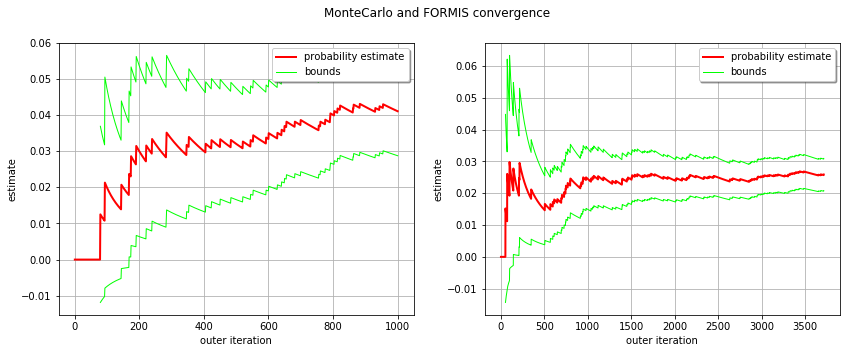

In [15]:
problem = otb.ReliabilityProblem57()
[
    computedProbability,
    absoluteError,
    numberOfCorrectDigits,
    numberOfFunctionEvaluationsMonteCarlo,
    graphMC,
] = otb.OTReliabilityAlgorithmBenchmark.MonteCarloSampling(problem)
[
    computedProbability,
    absoluteError,
    numberOfCorrectDigits,
    numberOfFunctionEvaluationsFORMIS,
    graphFORMIS,
] = otb.OTReliabilityAlgorithmBenchmark.FORMImportanceSampling(problem)

fig = pl.figure(figsize=(14, 5))
ax_1 = fig.add_subplot(1, 2, 1)
_ = otv.View(graphMC, figure=fig, axes=[ax_1])
ax_2 = fig.add_subplot(1, 2, 2)
_ = otv.View(graphFORMIS, figure=fig, axes=[ax_2])
_ = fig.suptitle("MonteCarlo and FORMIS convergence")

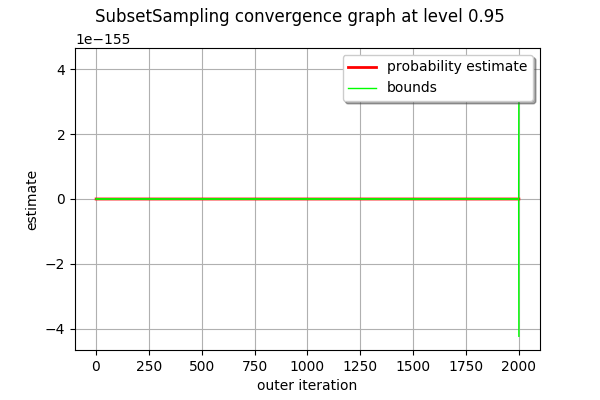

In [16]:
problem = otb.ReliabilityProblem60()
graphe3 = SubsetSampling(problem)[2]
graphe3

# Remarks

* We note that the FORM and SORM methods are faster, but, they do not converge to the exact proba.
* We also notice the effectiveness of the ImpotanceSampling method (inexpensive method, and converges).
* The convergence of the MonteCarlo method requires a large number of simulations.
* SubsetSampling converges even if the probability is very low.
